In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    './fruit-dataset',
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
)

Found 748 files belonging to 9 classes.


In [4]:
class_names = dataset.class_names
class_names

['apple',
 'banana',
 'grapes',
 'kiwi',
 'mango',
 'orange',
 'pineapple',
 'pomegranate',
 'watermelon']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(labels_batch.numpy())

[4 8 3 2 7 1 7 7 2 7 4 0 2 2 0 2 0 6 6 1 1 0 2 2 7 7 3 6 8 2 0 3]


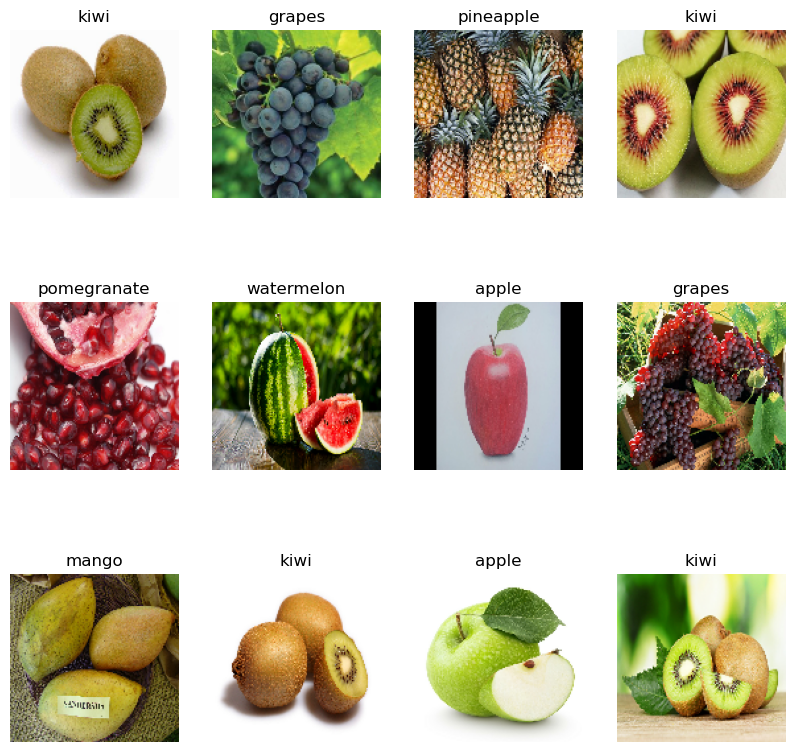

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [8]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

19

In [12]:
len(test_ds)

3

In [13]:
len(val_ds)

2

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 128, 128, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 126, 126, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (32, 63, 63, 16)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 61, 61, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 30, 30, 32)          0         
 g2D)                                                 

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
19/19 [==============================] - 25s 663ms/step - loss: 2.1985 - accuracy: 0.1151 - val_loss: 2.1867 - val_accuracy: 0.0682
Epoch 2/50
19/19 [==============================] - 20s 674ms/step - loss: 2.1819 - accuracy: 0.1293 - val_loss: 2.1233 - val_accuracy: 0.1719
Epoch 3/50
19/19 [==============================] - 19s 632ms/step - loss: 2.0890 - accuracy: 0.2072 - val_loss: 1.8924 - val_accuracy: 0.2969
Epoch 4/50
19/19 [==============================] - 19s 628ms/step - loss: 1.9273 - accuracy: 0.2568 - val_loss: 1.7588 - val_accuracy: 0.2969
Epoch 5/50
19/19 [==============================] - 19s 614ms/step - loss: 1.8191 - accuracy: 0.2891 - val_loss: 1.8393 - val_accuracy: 0.3125
Epoch 6/50
19/19 [==============================] - 19s 615ms/step - loss: 1.8464 - accuracy: 0.2857 - val_loss: 1.7820 - val_accuracy: 0.2656
Epoch 7/50
19/19 [==============================] - 19s 621ms/step - loss: 1.8391 - accuracy: 0.2806 - val_loss: 1.6581 - val_accuracy: 0.3636